In [39]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [40]:
def extract_simple_features(audio_path, sr=22050):
    """
extract features from an audion file using librosa.
    """
    try:
        # load audio file

        audio, _ = librosa.load(audio_path, sr=sr)
        
        # trim silence 
        audio = librosa.effects.trim(audio, top_db=20)[0]
        
        if len(audio) == 0:
            return None
        
        features = {}
        
        # MFCC ( most common features)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])
        
        # Spectral Features 
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        
        # Zero Crossing Rate (vibration rate)
        zcr = librosa.feature.zero_crossing_rate(audio)[0]
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        
        # Energy
        rms = librosa.feature.rms(y=audio)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
        
        # Spectral bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
        
        return features
        
    except Exception as e:
        print(f"error in {audio_path}: {e}")
        return None


In [41]:
def load_data(audio_folder, excel_file):
    """
    upload audio files and Excel files
    """
    #   Read labels from  Excel
    df_labels = pd.read_excel(excel_file, sheet_name='Parselmouth')
    
    # create a dictionary for labels  
    labels_dict = {}
    for _, row in df_labels.iterrows():
        sample_id = row['Sample ID']
        labels_dict[sample_id] = {
            'label': row['Label'],
            'age': row['Age'],
            'sex': 1 if row['Sex'] == 'M' else 0
        }
    
    features_list = []
    labels_list = []
    sample_ids = []
        
    #  analyse files in  WAV format
    processed_count = 0
    for filename in os.listdir(audio_folder):
        if filename.endswith('.wav'):
            sample_id = filename.replace('.wav', '')
            
            if sample_id in labels_dict:
                audio_path = os.path.join(audio_folder, filename)
                
                # feature extraction
                features = extract_simple_features(audio_path)
                
                if features is not None:
                    #  add demographic features  
                    features['age'] = labels_dict[sample_id]['age']
                    features['sex'] = labels_dict[sample_id]['sex']
                    
                    features_list.append(features)
                    labels_list.append(labels_dict[sample_id]['label'])
                    sample_ids.append(sample_id)
                    processed_count += 1
                    
                    if processed_count % 10 == 0:
                        print(f" files processed: {processed_count} ")
    
    print(f"sum of processed files: {processed_count}")
    
    # DataFrame
    features_df = pd.DataFrame(features_list)
    
    #labels  (HC=0, PwPD=1)
    labels_encoded = [1 if label == 'PwPD' else 0 for label in labels_list]
    
    return features_df, np.array(labels_encoded), sample_ids


In [42]:
def split_data_three_way(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
      split to   : train, validation, test
    """
    # first train و temp   
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=random_state, stratify=y
    )
    
    # then split temp to  validation and test  
    relative_val_size = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - relative_val_size), 
        random_state=random_state, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [43]:
def cross_validate_models(X_train, y_train, cv_folds=5):
    """
      compare models with cross-validation
    """
    models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest (50)': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
            'Decision Tree': DecisionTreeClassifier(max_depth=8, random_state=42),
            'Naive Bayes': GaussianNB(),
            'K-Neighbors (5)': KNeighborsClassifier(n_neighbors=5),
            'SVM Linear': SVC(kernel='linear', random_state=42, probability=True)
        }
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    results = {}
    
    print(f"\n compare models with   {cv_folds}-fold Cross-Validation:")
    print("="*60)
    
    for name, model in models.items():
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        results[name] = {
            'mean_accuracy': cv_scores.mean(),
            'std_accuracy': cv_scores.std(),
            'cv_scores': cv_scores,
            'model': model
        }
        
        print(f"{name:20}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"                     Individual folds: {cv_scores}")
    
    #   choose the best model
    best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
    print(f"\n best model : {best_model_name}")
    
    return results, best_model_name


In [44]:
def train_and_evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    train and evaluate model on 3 dataset
    """
    # normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # train model
    model.fit(X_train_scaled, y_train)
    
    #prediction on 3 dataset
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # accuracy calculation 
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"\n evaluation outcome:")
    print(f"{'='*50}")
    print(f" Train accuracy:      {train_accuracy:.4f}")
    print(f" Validation: {val_accuracy:.4f}")
    print(f" Test:       {test_accuracy:.4f}")
    
    #  AUC for validation & test
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        val_auc = roc_auc_score(y_val, y_val_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        print(f"AUC Validation:  {val_auc:.4f}")
        print(f"AUC Test:        {test_auc:.4f}")
    
    return model, scaler, y_val_pred, y_test_pred


In [45]:
def plot_comprehensive_analysis(model, scaler, X_train, X_val, X_test, 
                               y_train, y_val, y_test, feature_names):
    """
      comprehensive analysis and visualization of model results  
    """
    #  normalization
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # prediction on  dataset
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    #  subplot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('   comprehensive PD prediction analysis ', fontsize=16)
    
    # 1. Confusion Matrix - Validation
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Healthy', 'Parkinson'],
                yticklabels=['Healthy', 'Parkinson'])
    axes[0,0].set_title('Confusion Matrix - Validation')
    axes[0,0].set_ylabel('Actual')
    axes[0,0].set_xlabel('Predicted')
    
    # 2. Confusion Matrix - Test
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
                xticklabels=['Healthy', 'Parkinson'],
                yticklabels=['Healthy', 'Parkinson'])
    axes[0,1].set_title('Confusion Matrix - Test')
    axes[0,1].set_ylabel('Actual')
    axes[0,1].set_xlabel('Predicted')
    
    # 3. ROC Curve
    if hasattr(model, 'predict_proba'):
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
        
        axes[0,2].plot(fpr_val, tpr_val, 'b-', label=f'Validation (AUC = {roc_auc_score(y_val, y_val_proba):.3f})')
        axes[0,2].plot(fpr_test, tpr_test, 'r-', label=f'Test (AUC = {roc_auc_score(y_test, y_test_proba):.3f})')
        axes[0,2].plot([0, 1], [0, 1], 'k--')
        axes[0,2].set_xlabel('False Positive Rate')
        axes[0,2].set_ylabel('True Positive Rate')
        axes[0,2].set_title('ROC Curve')
        axes[0,2].legend()
    
    # 4. Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        axes[1,0].bar(range(15), importances[indices])
        axes[1,0].set_title('Top 15 Feature Importances')
        axes[1,0].set_xlabel('Features')
        axes[1,0].set_ylabel('Importance')
        axes[1,0].set_xticks(range(15))
        axes[1,0].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
    
    # 5. Precision-Recall Curve
    if hasattr(model, 'predict_proba'):
        precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
        precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
        
        axes[1,1].plot(recall_val, precision_val, 'b-', label='Validation')
        axes[1,1].plot(recall_test, precision_test, 'r-', label='Test')
        axes[1,1].set_xlabel('Recall')
        axes[1,1].set_ylabel('Precision')
        axes[1,1].set_title('Precision-Recall Curve')
        axes[1,1].legend()
    
    # 6. Data Distribution
    data_sizes = [len(y_train), len(y_val), len(y_test)]
    labels = ['Train', 'Validation', 'Test']
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    axes[1,2].bar(labels, data_sizes, color=colors)
    axes[1,2].set_title('Dataset Size Distribution')
    axes[1,2].set_ylabel('Number of Samples')
    
    # add values on top of bars 
    for i, v in enumerate(data_sizes):
        axes[1,2].text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


In [46]:
def detailed_classification_report(y_true, y_pred, dataset_name):
    """
    classification reprt
    """
    print(f"\n{dataset_name} Dataset - Classification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred, 
                              target_names=['Healthy (HC)', 'Parkinson (PwPD)'],
                              digits=4))
    
    #   additional metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity:          {specificity:.4f}")
    print(f"True Positives:       {tp}")
    print(f"True Negatives:       {tn}")
    print(f"False Positives:      {fp}")
    print(f"False Negatives:      {fn}")


In [47]:
def print_feature_importance_table(model, feature_names, top_n=20):
    """
     feature importance table 
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print(f"\nTop {top_n} Most Important Features:")
        print("="*60)
        print(f"{'Rank':<4} {'Feature Name':<30} {'Importance':<12}")
        print("-"*60)
        
        for i in range(min(top_n, len(indices))):
            idx = indices[i]
            print(f"{i+1:<4} {feature_names[idx]:<30} {importances[idx]:<12.6f}")


In [48]:
def main():
    """
    main function with comprehensive analysis
    """
    #  path settings
    AUDIO_FOLDER = "/home/najme/projects/Parkinson_SP/audio"  #audio path .wav
    EXCEL_FILE = "/home/najme/projects/Parkinson_SP/Demographics_age_sex.xlsx"  # Excel
    
    try:
        #check file existence
        if not os.path.exists(EXCEL_FILE):
            print(f" Excel file not found : {EXCEL_FILE}")
            return
        
        # 1. loading data 
        print(" first step : loading and processing data")
        print("="*50)
        features_df, labels, sample_ids = load_data(AUDIO_FOLDER, EXCEL_FILE)
        
        if len(features_df) == 0:
            print("There is no data processed!")
            return
        
        #  information display 
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\n data statistic:")
        print(f" total features : {len(features_df)}")
        print(f" num of features : {len(features_df.columns)}")
        print(f"num of healty indiviuals  (HC): {counts[0]}")
        print(f"num of PD patients   (PwPD): {counts[1]}")
        
        # 2.  divide data
        print(f"\n step 2:  ")
        print("="*50)
        X_train, X_val, X_test, y_train, y_val, y_test = split_data_three_way(
            features_df, labels, test_size=0.2, val_size=0.2
        )
        
        print(f"Train set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        # 3.   compare models with  Cross-Validation
        print(f"\n step3:comare models  ")
        print("="*50)
        results, best_model_name = cross_validate_models(X_train, y_train, cv_folds=5)
        
        # 4.  train final model 
        print(f"\n step 4:   train final model ({best_model_name})")
        print("="*50)
        best_model = results[best_model_name]['model']
        
        model, scaler, y_val_pred, y_test_pred = train_and_evaluate_model(
            best_model, X_train, X_val, X_test, y_train, y_val, y_test
        )
        
        # 5.comprehensive analysis
        print(f"\n step 5: comprehensive analysis")
        print("="*50)
        
        # detail report validation & test
        detailed_classification_report(y_val, y_val_pred, "Validation")
        detailed_classification_report(y_test, y_test_pred, "Test")
        
        #   feature importance table
        print_feature_importance_table(model, features_df.columns.tolist(), top_n=20)
        
        # 6. illustrate analytical images 
        print(f"\n step 6: analytical images")
        print("="*50)
        plot_comprehensive_analysis(model, scaler, X_train, X_val, X_test, 
                                   y_train, y_val, y_test, features_df.columns.tolist())
        
        # 7.  save model
        print(f"\n step 7:  save model")
        print("="*50)
        import joblib
        
        model_data = {
            'model': model,
            'scaler': scaler,
            'feature_names': features_df.columns.tolist(),
            'best_model_name': best_model_name,
            'cv_results': results
        }
        
        joblib.dump(model_data, 'enhanced_parkinson_model.pkl')
        print("   model saved successfuly: enhanced_parkinson_model.pkl")
        
        print(f"\n{'='*60}")
        print(" train and data evaluation has compeleted! ✅")
        print(f" best model: {best_model_name}")
        print(f"number of samples : {len(features_df)}")
        print(f"number of features : {len(features_df.columns)}")
        print(f"{'='*60}")
        
        return model, scaler, features_df.columns.tolist()
        
    except Exception as e:
        print(f" error in   : {e}")
        return None, None, None


In [49]:
def predict_new_audio(model, scaler, feature_names, audio_path):
    """
     predict for a new audio file
    """
    # extract features from audio file 
    features = extract_simple_features(audio_path)
    
    if features is None:
        return None
    
    #   DataFrame
    features_df = pd.DataFrame([features])
    
    #  be sure all features are present   
    for feature in feature_names:
        if feature not in features_df.columns:
            features_df[feature] = 0
    
    # features order
    features_df = features_df[feature_names]
    
    # normalization
    features_scaled = scaler.transform(features_df)
    
    # prediction
    prediction = model.predict(features_scaled)[0]
    
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(features_scaled)[0]
        confidence = max(probability) * 100
    else:
        probability = None
        confidence = None
    
    result = "Parkinson (PwPD)" if prediction == 1 else "Healthy (HC)"
    
    return result, confidence, probability


 first step : loading and processing data
 files processed: 10 
 files processed: 20 
 files processed: 30 
 files processed: 40 
 files processed: 50 
 files processed: 60 
 files processed: 70 
 files processed: 80 
sum of processed files: 81

 data statistic:
 total features : 81
 num of features : 40
num of healty indiviuals  (HC): 41
num of PD patients   (PwPD): 40

 step 2:  
Train set: 48 samples
Validation set: 16 samples
Test set: 17 samples

 step3:comare models  

 compare models with   5-fold Cross-Validation:
Logistic Regression : 0.7756 (+/- 0.1851)
                     Individual folds: [0.7        0.7        0.7        0.88888889 0.88888889]
Random Forest (50)  : 0.8133 (+/- 0.1483)
                     Individual folds: [0.7        0.9        0.8        0.77777778 0.88888889]
Decision Tree       : 0.8089 (+/- 0.2152)
                     Individual folds: [0.8        0.8        1.         0.66666667 0.77777778]
Naive Bayes         : 0.7111 (+/- 0.1311)
                

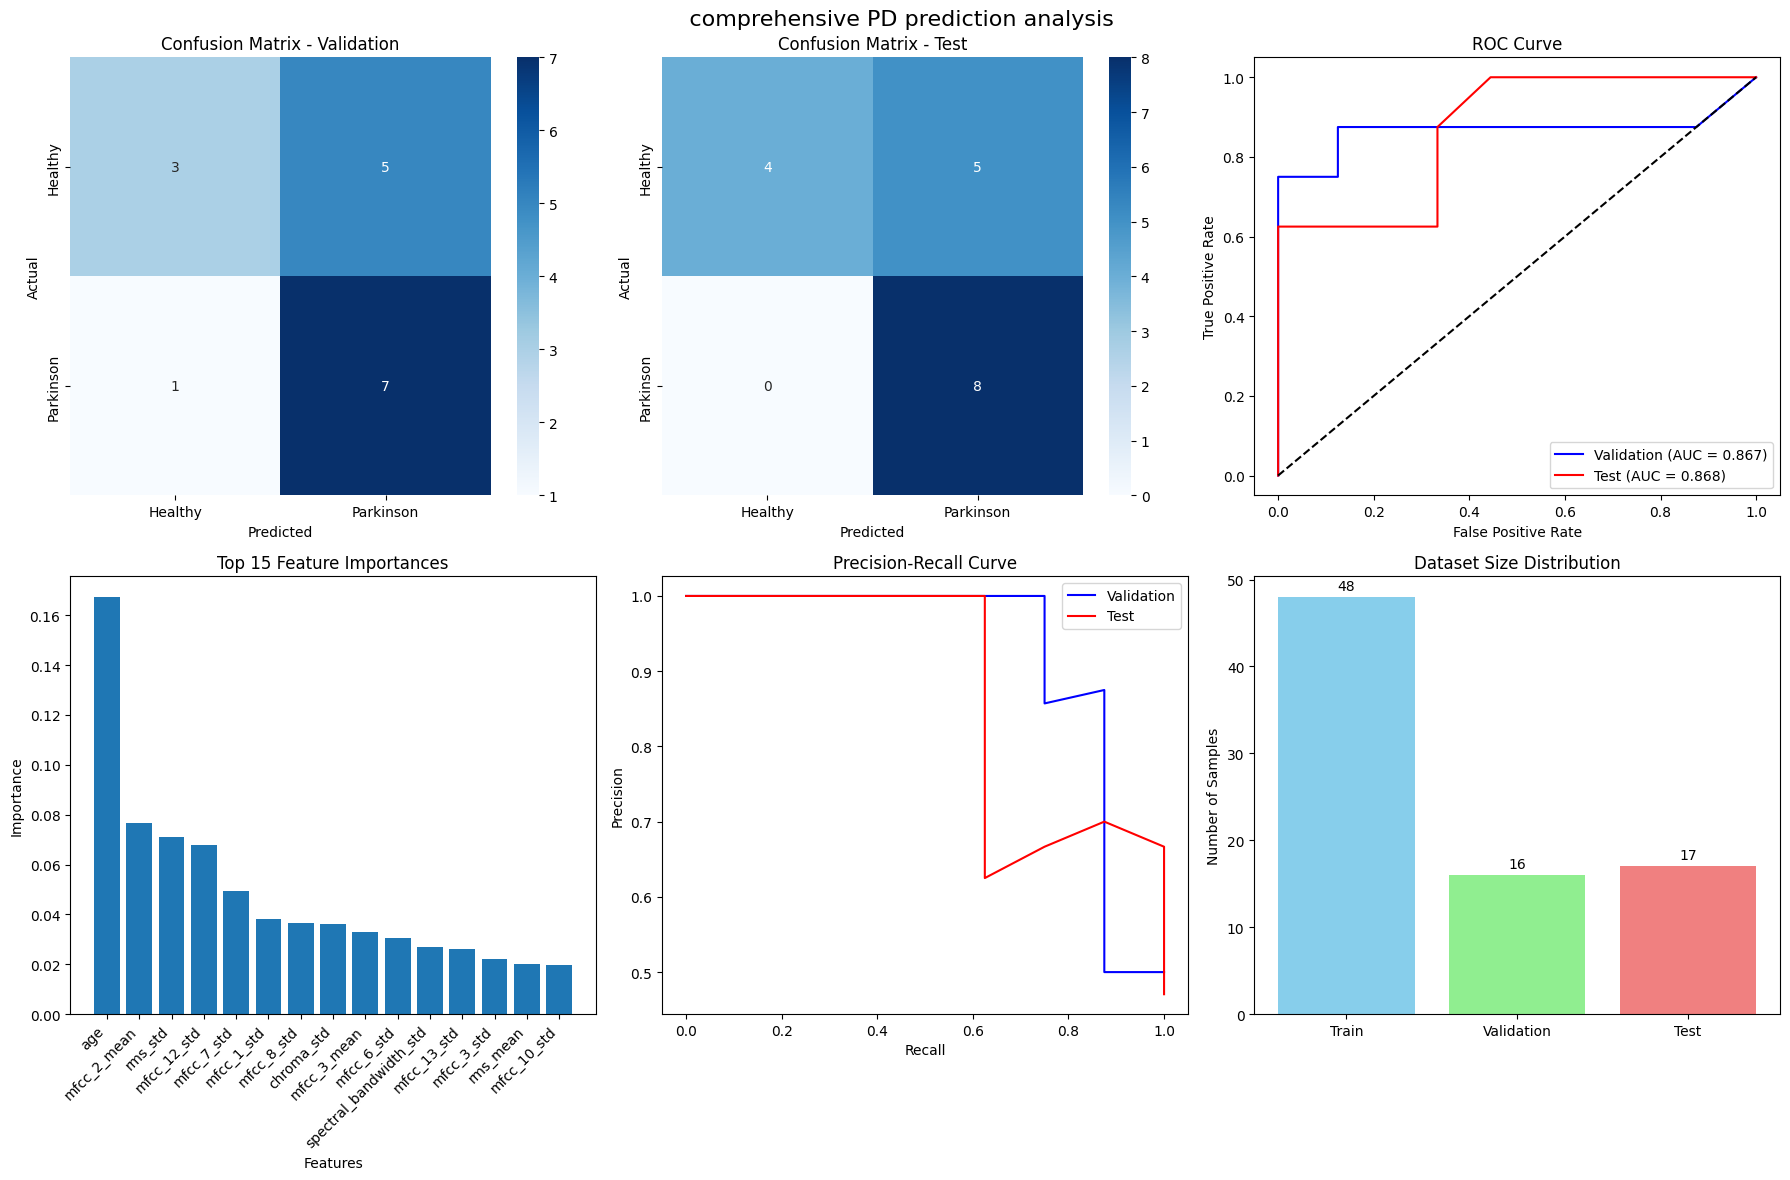


 step 7:  save model
   model saved successfuly: enhanced_parkinson_model.pkl

 train and data evaluation has compeleted! ✅
 best model: Random Forest (50)
number of samples : 81
number of features : 40


In [50]:
if __name__ == "__main__":
    model, scaler, feature_names = main()
    